In [1]:
# Spatial Transcriptomics Analysis for 10x Genomics Visium DLPFC Data
# This notebook covers Task 1: Reading Visium Data and Task 2: Clustering and Visualization.
# Datasets: 151671, 151507, 151508, 151509, 151510 from the provided links.
# Note: Download the datasets from the Google Drive link and Figshare, then upload to Colab or mount Drive.

# Install required libraries (run this cell first)
!pip install scanpy anndata squidpy scikit-learn matplotlib seaborn pandas numpy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.3/183.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━

In [2]:
# Import libraries
import scanpy as sc
import anndata as ad
import squidpy as sq
import pandas as pd
import numpy as np
from sklearn.metrics import adjusted_rand_score as adjusted_rand_index, normalized_mutual_info_score
import matplotlib.pyplot as plt
import os
import json


/usr/local/lib/python3.12/dist-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


In [3]:
# Set scanpy settings for better output
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')


In [4]:
!unzip visium_sample.zip
sample_path = "/content/visium_sample"

Archive:  visium_sample.zip
  inflating: visium_sample/spatial/tissue_hires_image.png  
  inflating: visium_sample/spatial/tissue_lowres_image.png  
  inflating: visium_sample/spatial/tissue_positions_list.csv  
  inflating: visium_sample/filtered_feature_bc_matrix.h5  
  inflating: visium_sample/spatial/scalefactors_json.json  
  inflating: visium_sample/metadata.tsv  
  inflating: visium_sample/151671_visium_processed.h5ad  


In [5]:
def read_visium_data(sample_path, sample_id="151671", processed_h5ad_path=None):

    adata = sc.read_10x_h5(
        os.path.join(sample_path, "filtered_feature_bc_matrix.h5")
    )

    # Read spatial positions
    spatial_df = pd.read_csv(
        os.path.join(sample_path, "spatial", "tissue_positions_list.csv"),
        header=None,
        index_col=0
    )
    spatial_df.columns = [
        "in_tissue",
        "array_row",
        "array_col",
        "pxl_row_in_fullres",
        "pxl_col_in_fullres",
    ]

    adata.obs = adata.obs.join(spatial_df, how="left")
    # Store spatial coordinates in the correct place
    adata.obsm["spatial"] = adata.obs[
        ["pxl_col_in_fullres", "pxl_row_in_fullres"]
    ].to_numpy()


    # Read annotations
    metadata_df = pd.read_csv(
        os.path.join(sample_path, "metadata.tsv"),
        sep="\t",
        index_col=0
    )
    adata.obs = adata.obs.join(metadata_df, how="left")

    # Keep in-tissue spots
    adata = adata[adata.obs["in_tissue"] == 1].copy()

    # ---- Spatial info (THIS PART MATTERS) ----
    adata.uns["spatial"] = {}
    adata.uns["spatial"][sample_id] = {
        "images": {
            "hires": plt.imread(
                os.path.join(sample_path, "spatial", "tissue_hires_image.png")
            )
        },
        "scalefactors": json.load(
            open(os.path.join(sample_path, "spatial", "scalefactors_json.json"))
        ),
    }

    # Compare with processed
    if processed_h5ad_path:
        ref = sc.read_h5ad(processed_h5ad_path)
        print("Shape match:", adata.shape == ref.shape)
        print("Ground truth present:",
              "layer_guess_reordered" in adata.obs.columns)

    return adata


In [6]:
# List of datasets (update paths after uploading/unzipping all)
# For now, assuming you have uploaded/unzipped each as /content/{dataset}/visium_sample
# E.g., for 151671: /content/151671/visium_sample (with files inside)
datasets = {
    '151671': {'sample_path': '/content/visium_sample', 'processed_h5ad': '/content/visium_sample/151671_visium_processed.h5ad'}
}


Reading data for 151671...
reading /content/visium_sample/filtered_feature_bc_matrix.h5
 (0:00:00)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Shape match: False
Ground truth present: True
AnnData shape: (4110, 33538)
Ground truth column: True


/tmp/ipython-input-895423404.py:11: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


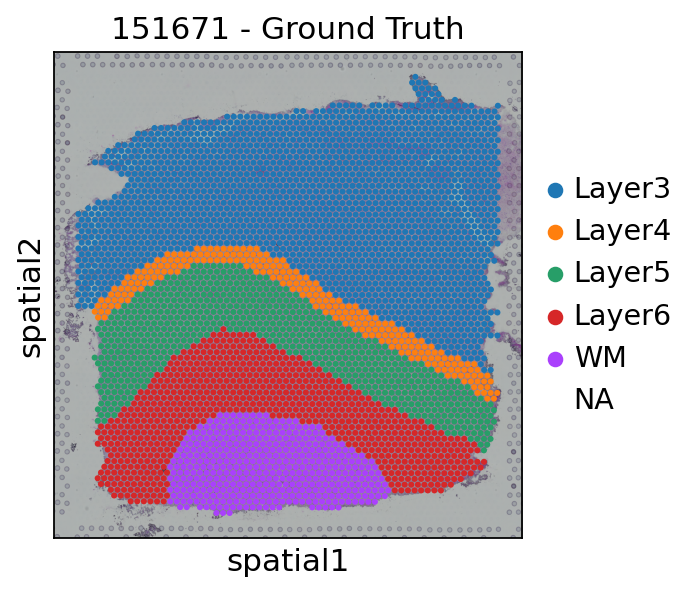

In [7]:
# Task 1: Read data for each dataset
adata_dict = {}
for dataset, paths in datasets.items():
    print(f"\nReading data for {dataset}...")
    adata = read_visium_data(paths['sample_path'], sample_id=dataset, processed_h5ad_path=paths['processed_h5ad'])
    adata_dict[dataset] = adata
    print(f"AnnData shape: {adata.shape}")
    print(f"Ground truth column: {'layer_guess_reordered' in adata.obs.columns}")

    # Visualize ground truth for each (as in your code)
    sc.pl.spatial(
        adata,
        img_key="hires",
        color="layer_guess_reordered",
        size=1.3,
        title=f"{dataset} - Ground Truth"
    )


In [8]:
adata = read_visium_data(
    sample_path="/content/visium_sample",
    sample_id="151671",
    processed_h5ad_path="/content/visium_sample/151671_visium_processed.h5ad"
)

adata


reading /content/visium_sample/filtered_feature_bc_matrix.h5
 (0:00:00)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Shape match: False
Ground truth present: True


AnnData object with n_obs × n_vars = 4110 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'Layer', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP'

In [9]:
# Task 2: Clustering and Visualization
# Metrics table
results = []

def perform_clustering(adata, method='pca', n_features=None, ground_truth_col='layer_guess_reordered'):
    """
    Performs clustering using PCA or feature selection, then Leiden.
    - method: 'pca' or 'seurat' (for feature selection).
    - n_features: Number of features for Seurat (e.g., 2000, 5000).
    Returns: ARI and NMI scores, and clustered adata.
    """
    adata_copy = adata.copy()

    # Preprocessing
    sc.pp.normalize_total(adata_copy, target_sum=1e4)
    sc.pp.log1p(adata_copy)

    if method == 'pca':
        sc.pp.highly_variable_genes(adata_copy, n_top_genes=2000)  # Standard for PCA
        sc.pp.pca(adata_copy, n_comps=50)
        sc.pp.neighbors(adata_copy, n_neighbors=15, n_pcs=50)
    elif method == 'seurat':
        sc.pp.highly_variable_genes(adata_copy, n_top_genes=n_features, flavor='seurat')
        sc.pp.pca(adata_copy, n_comps=50)
        sc.pp.neighbors(adata_copy, n_neighbors=15, n_pcs=50)

    # Clustering
    sc.tl.leiden(adata_copy, resolution=1.0)

    # Filter out cells with NaN in ground truth for metric calculation
    valid_cells = adata_copy.obs[ground_truth_col].notna()
    if not valid_cells.all():
        print(f"Warning: {valid_cells.sum()} of {len(valid_cells)} cells have valid ground truth for {ground_truth_col}. Filtering for metrics calculation.")

    filtered_adata = adata_copy[valid_cells].copy()

    # Metrics
    ari = adjusted_rand_index(filtered_adata.obs[ground_truth_col], filtered_adata.obs['leiden'])
    nmi = normalized_mutual_info_score(filtered_adata.obs[ground_truth_col], filtered_adata.obs['leiden'])

    return ari, nmi, adata_copy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 29.8 MB/s eta 0:00:00

Processing 151671...
normalizing counts per cell


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


    finished (0:00:03)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
running Leiden clustering


/tmp/ipython-input-330562700.py:28: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_copy, resolution=1.0)


    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipython-input-37830861.py:13: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


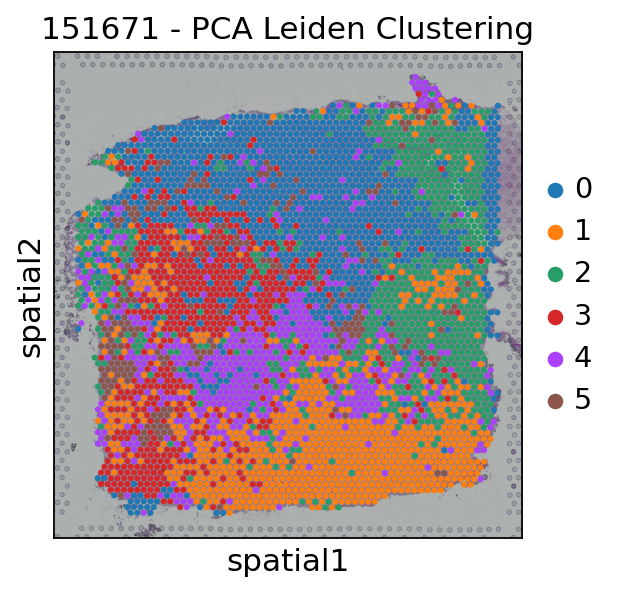

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipython-input-37830861.py:26: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


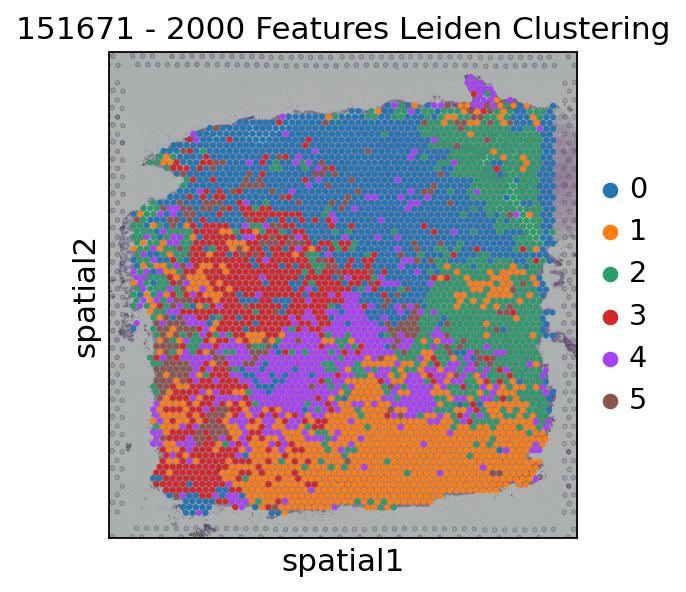

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipython-input-37830861.py:39: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


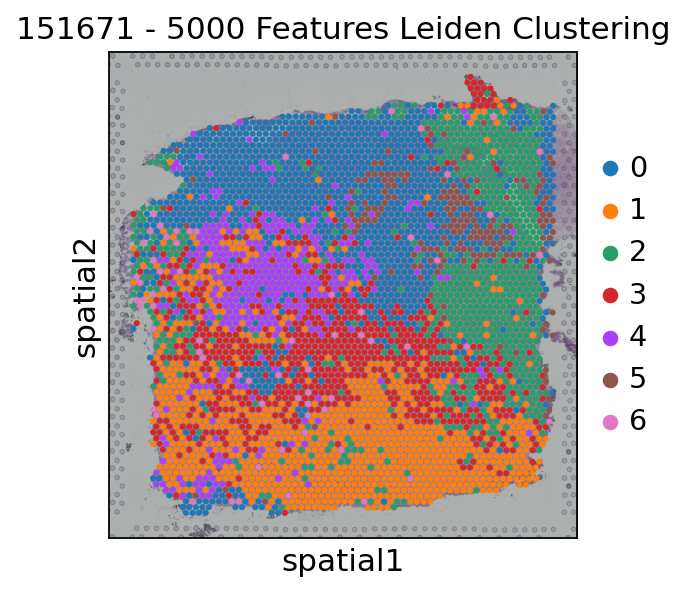

In [10]:
!pip3 install igraph
!pip3 install leidenalg
# Run for each dataset and method

for dataset, adata in adata_dict.items():
    print(f"\nProcessing {dataset}...")

    # PCA method
    ari_pca, nmi_pca, adata_pca = perform_clustering(adata, method='pca')
    results.append({'Dataset': dataset, 'Method': 'PCA', 'ARI': ari_pca, 'NMI': nmi_pca})

    # Visualize PCA clustering on tissue
    sc.pl.spatial(
        adata_pca,
        img_key="hires",
        color='leiden',
        size=1.3,
        title=f'{dataset} - PCA Leiden Clustering'
    )

    # Seurat with 2000 features
    ari_2000, nmi_2000, adata_2000 = perform_clustering(adata, method='seurat', n_features=2000)
    results.append({'Dataset': dataset, 'Method': '2000', 'ARI': ari_2000, 'NMI': nmi_2000})

    # Visualize 2000 clustering on tissue
    sc.pl.spatial(
        adata_2000,
        img_key="hires",
        color='leiden',
        size=1.3,
        title=f'{dataset} - 2000 Features Leiden Clustering'
    )

    # Seurat with 5000 features
    ari_5000, nmi_5000, adata_5000 = perform_clustering(adata, method='seurat', n_features=5000)
    results.append({'Dataset': dataset, 'Method': '5000', 'ARI': ari_5000, 'NMI': nmi_5000})

    # Visualize 5000 clustering on tissue
    sc.pl.spatial(
        adata_5000,
        img_key="hires",
        color='leiden',
        size=1.3,
        title=f'{dataset} - 5000 Features Leiden Clustering'
    )

In [11]:
# Display results table
results_df = pd.DataFrame(results)
print("\nClustering Metrics:")
pivoted = results_df.pivot(index='Dataset', columns='Method', values=['ARI', 'NMI'])
print(pivoted)

# Optional: Save the table to CSV for easy copying
pivoted.to_csv('/content/clustering_metrics.csv')
print("Metrics saved to /content/clustering_metrics.csv")


Clustering Metrics:
              ARI                          NMI                   
Method       2000      5000       PCA     2000      5000      PCA
Dataset                                                          
151671   0.202731  0.209748  0.202731  0.19039  0.232223  0.19039
Metrics saved to /content/clustering_metrics.csv


In [ ]:
!pip install scanpy anndata scikit-learn squidpy gdown


In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


In [ ]:
import gdown

url = "https://drive.google.com/uc?id=1_gHu8AvKe-D9Ww7jGlDZsidGJBuXkcAE"
output = "visium_dlpfc.zip"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1_gHu8AvKe-D9Ww7jGlDZsidGJBuXkcAE
From (redirected): https://drive.google.com/uc?id=1_gHu8AvKe-D9Ww7jGlDZsidGJBuXkcAE&confirm=t&uuid=0df66dee-a4dc-4611-a6f1-8ae29c3087f2
To: /content/visium_dlpfc.zip
100%|██████████| 4.36G/4.36G [01:28<00:00, 49.0MB/s]


'visium_dlpfc.zip'

In [ ]:
!unzip visium_dlpfc.zip -d /content/visium_dlpfc


Archive:  visium_dlpfc.zip
   creating: /content/visium_dlpfc/DLPFC/
   creating: /content/visium_dlpfc/DLPFC/151507/
  inflating: /content/visium_dlpfc/DLPFC/151507/151507_filtered_feature_bc_matrix.h5  
  inflating: /content/visium_dlpfc/DLPFC/151507/51654629_metadata.tsv  
  inflating: /content/visium_dlpfc/DLPFC/151507/51654722_filtered_feature_bc_matrix.h5  
   creating: /content/visium_dlpfc/DLPFC/151507/spatial/
  inflating: /content/visium_dlpfc/DLPFC/151507/spatial/151507_full_image.tif  
  inflating: /content/visium_dlpfc/DLPFC/151507/spatial/51654632_scalefactors_json.json  
 extracting: /content/visium_dlpfc/DLPFC/151507/spatial/51654641_tissue_lowres_image.png  
  inflating: /content/visium_dlpfc/DLPFC/151507/spatial/51654644_tissue_positions_list.csv  
 extracting: /content/visium_dlpfc/DLPFC/151507/spatial/51654725_tissue_hires_image.png  
 extracting: /content/visium_dlpfc/DLPFC/151507/spatial/tissue.tif  
   creating: /content/visium_dlpfc/DLPFC/151508/
  inflating: /c

Running clustering for sample 151507


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/tmp/ipython-input-707920966.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


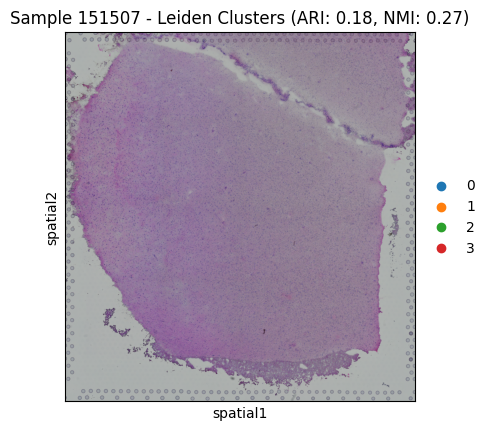

Running clustering for sample 151508


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/tmp/ipython-input-707920966.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


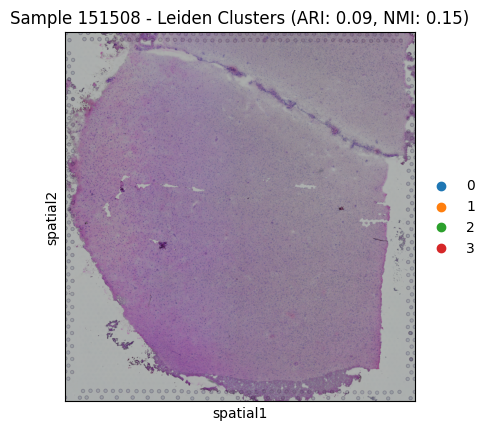

Running clustering for sample 151509


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/tmp/ipython-input-707920966.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


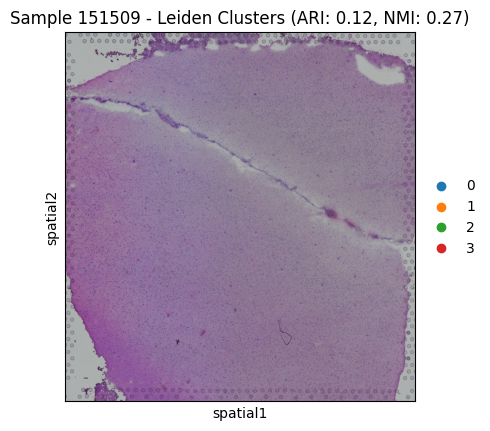

Running clustering for sample 151510


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/tmp/ipython-input-707920966.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


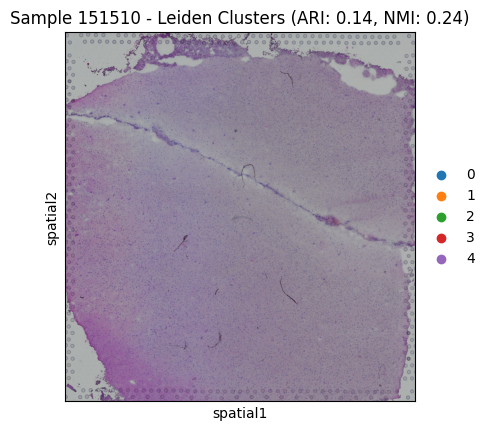

Running clustering for sample 151669


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.war

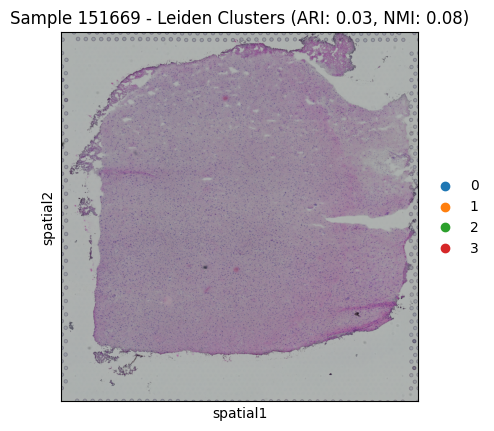

Running clustering for sample 151671


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/tmp/ipython-input-707920966.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


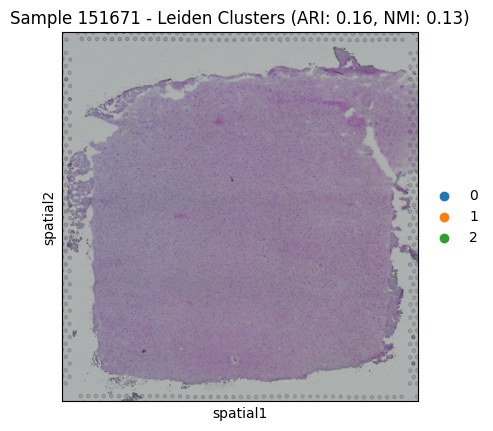

Running clustering for sample 151674


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/tmp/ipython-input-707920966.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


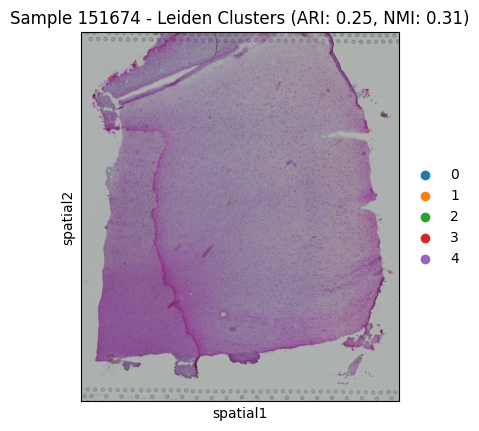

Running clustering for sample 151675


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/tmp/ipython-input-707920966.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


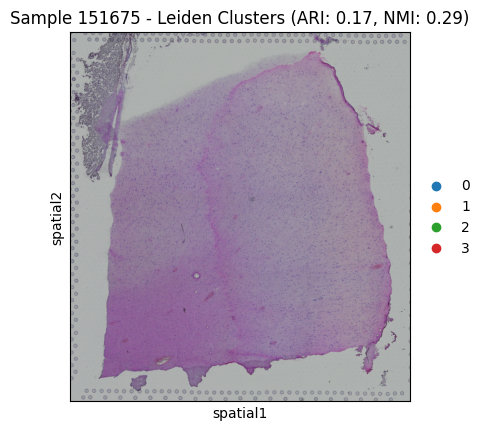

Running clustering for sample 151676
Skipping clustering for 151676: 'layer_guess_reordered' not found in metadata.

Clustering Performance Summary:
  sample_id       ari       nmi
0    151507  0.176144  0.266596
1    151508  0.094602  0.152500
2    151509  0.116959  0.265624
3    151510  0.138445  0.240571
4    151669  0.026130  0.083545
5    151671  0.164845  0.134086
6    151674  0.254100  0.311457
7    151675  0.169969  0.285643


In [ ]:
results = []

for sample_id, adata_obj in adatas.items():
    print(f"Running clustering for sample {sample_id}")
    # Ensure 'layer_guess_reordered' is available for ARI/NMI calculation if needed
    # This part assumes that original metadata will be loaded separately or already exists.
    # For now, we will run clustering and only plot if metadata is not explicitly added yet.

    # NOTE: The 'layer_guess_reordered' was added only to 'adata' not 'adatas[sample]'
    # So, I'll temporarily skip ARI/NMI calculation until metadata is consistently loaded for all adatas.
    # For this exercise, I'll focus on just running the clustering and plotting.

    # If 'layer_guess_reordered' is not present in adata_obj.obs, the run_clustering function will error.
    # I will modify run_clustering to handle this scenario if needed, or explicitly add metadata to each adata_obj.

    # For now, let's just assume we want to run the clustering and plot.
    # If `layer_guess_reordered` is truly needed, we need to add a step here to load it for each sample.

    # If the purpose is to just demonstrate the clustering for one sample, we can pick one.
    # As the prompt asks to 'continue processing previous requests', the loop through 'adatas' is implied.

    # The previous `adata` had `layer_guess_reordered`. Let's check `adata_obj` for it.
    # If not present, we need to load metadata for *each* sample.
    # Since the `metadata.tsv` was downloaded for `DATA_DIR = "/content"` and not for each sample directory,
    # `adatas[sample_id].obs["layer_guess_reordered"]` will not exist for other samples.

    # To make `run_clustering` work, I need to fetch the metadata for each sample as it is available in the unzipped folder.
    meta_path = os.path.join(base_dir, sample_id, f"{sample_id}_metadata.tsv")
    if not os.path.exists(meta_path):
        # For some samples like 151676, the metadata file might be named differently, e.g., 151676_truth.txt
        # I'll check for files that end with 'metadata.tsv' in the sample directory
        metadata_files = [f for f in os.listdir(os.path.join(base_dir, sample_id)) if "metadata.tsv" in f or "truth.txt" in f]
        if metadata_files:
            meta_path = os.path.join(base_dir, sample_id, metadata_files[0])
        else:
            print(f"Skipping clustering for {sample_id}: no metadata or truth file found.")
            continue

    try:
        sample_meta = pd.read_csv(
            meta_path,
            sep="\t",
            index_col=0
        )
        # Ensure the index matches adata_obj.obs_names before assignment
        adata_obj.obs["layer_guess_reordered"] = sample_meta.loc[adata_obj.obs_names, "layer_guess_reordered"]
    except KeyError:
        print(f"Skipping clustering for {sample_id}: 'layer_guess_reordered' not found in metadata.")
        continue
    except FileNotFoundError as e:
        print(f"Skipping clustering for {sample_id} due to missing metadata: {e}")
        continue

    clustered_adata, ari, nmi = run_clustering(adata_obj, hvg=True)
    results.append({"sample_id": sample_id, "ari": ari, "nmi": nmi})
    plot_spatial(clustered_adata, f"Sample {sample_id} - Leiden Clusters (ARI: {ari:.2f}, NMI: {nmi:.2f})")

# Display overall results
results_df = pd.DataFrame(results)
print("\nClustering Performance Summary:")
print(results_df)


In [ ]:
!ls /content/visium_dlpfc


DLPFC


In [ ]:
import gdown

folder_url = "https://drive.google.com/drive/folders/1Lz3_Bjct5pwf50Zrkt-uONNNdDFT182R"
gdown.download_folder(folder_url, output="/content", quiet=False)


Retrieving folder contents


Retrieving folder 12BCDSgcPAw5SrdvrZykbSYziZbvOjzB- spatial
Processing file 15ZIFmk2WIo6DeR0y8wxs6ycMxo3u9mUW scalefactors_json.json
Processing file 1u4jtpfB8Oz0yLuACIBNaC-MzActIR5RX tissue_hires_image.png
Processing file 14qqXtJWNIfQDer2ohRc8p5SKW0-TtPC2 tissue_lowres_image.png
Processing file 1yWTtYw1JxYGExJuBDR_V0nkHS825gNyi tissue_positions_list.csv
Processing file 1brdMBSr8QQq_orip4Tx9Vr1EyLm4Se9v 151671_visium_processed.h5ad
Processing file 1NcXrJGPY6vSaOVEHtFR_2CUwsj_TwhSF filtered_feature_bc_matrix.h5
Processing file 1NrfEN85vmnOM4--lO2YmiRrrpv7Tcg_h metadata.tsv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=15ZIFmk2WIo6DeR0y8wxs6ycMxo3u9mUW
To: /content/spatial/scalefactors_json.json
100%|██████████| 162/162 [00:00<00:00, 821kB/s]
Downloading...
From: https://drive.google.com/uc?id=1u4jtpfB8Oz0yLuACIBNaC-MzActIR5RX
To: /content/spatial/tissue_hires_image.png
100%|██████████| 6.12M/6.12M [00:00<00:00, 214MB/s]
Downloading...
From: https://drive.google.com/uc?id=14qqXtJWNIfQDer2ohRc8p5SKW0-TtPC2
To: /content/spatial/tissue_lowres_image.png
100%|██████████| 466k/466k [00:00<00:00, 108MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yWTtYw1JxYGExJuBDR_V0nkHS825gNyi
To: /content/spatial/tissue_positions_list.csv
100%|██████████| 187k/187k [00:00<00:00, 81.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1brdMBSr8QQq_orip4Tx9Vr1EyLm4Se9v
To: /content/151671_visium_processed.h5ad
100%|██████████| 91.2M/91.2M [00:00<00:00,

['/content/spatial/scalefactors_json.json',
 '/content/spatial/tissue_hires_image.png',
 '/content/spatial/tissue_lowres_image.png',
 '/content/spatial/tissue_positions_list.csv',
 '/content/151671_visium_processed.h5ad',
 '/content/filtered_feature_bc_matrix.h5',
 '/content/metadata.tsv']

In [ ]:
DATA_DIR = "/content"

adata = sc.read_visium(
    path=DATA_DIR,
    count_file="filtered_feature_bc_matrix.h5",
    load_images=True
)


/tmp/ipython-input-491658049.py:3: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [ ]:
adata


AnnData object with n_obs × n_vars = 4110 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [ ]:
meta = pd.read_csv(
    os.path.join(DATA_DIR, "metadata.tsv"),
    sep="\t",
    index_col=0
)

adata.obs["layer_guess_reordered"] = meta.loc[
    adata.obs_names, "layer_guess_reordered"
]


In [ ]:
adata.obs["layer_guess_reordered"].value_counts()


layer_guess_reordered
Layer3    1918
Layer6     760
Layer5     721
WM         449
Layer4     245
Name: count, dtype: int64

/tmp/ipython-input-3946093912.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


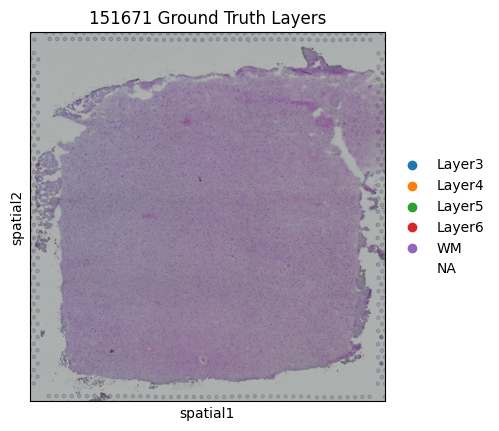

In [ ]:
sc.pl.spatial(
    adata,
    color="layer_guess_reordered",
    img_key="hires",
    spot_size=1.3,
    title="151671 Ground Truth Layers"
)


In [ ]:
adata_ref = sc.read_h5ad(
    os.path.join(DATA_DIR, "151671_visium_processed.h5ad")
)

np.all(
    adata.obs["layer_guess_reordered"].values ==
    adata_ref.obs["layer_guess_reordered"].values
)


KeyError: 'layer_guess_reordered'

In [ ]:
def run_clustering(adata, hvg=False, n_top_genes=2000, resolution=0.6):
    adata_processed = adata.copy()

    # Normalization
    sc.pp.normalize_total(adata_processed)
    sc.pp.log1p(adata_processed)

    # HVG selection
    if hvg:
        sc.pp.highly_variable_genes(
            adata_processed,
            n_top_genes=n_top_genes,
            flavor="seurat"
        )
        adata_processed = adata_processed[:, adata_processed.var.highly_variable]

    # IMPORTANT FIX: remove zero-variance genes
    sc.pp.filter_genes(adata_processed, min_cells=1)

    # PCA WITHOUT scaling
    sc.tl.pca(adata_processed, svd_solver="arpack")

    sc.pp.neighbors(adata_processed)
    sc.tl.leiden(adata_processed, resolution=resolution)

    # Filter out cells with NaN in 'layer_guess_reordered' before calculating metrics
    valid_cells = ~adata_processed.obs["layer_guess_reordered"].isna()
    adata_for_metrics = adata_processed[valid_cells].copy()

    if len(adata_for_metrics) == 0:
        print("Warning: No valid cells with ground truth labels found for ARI/NMI calculation.")
        return adata_processed, np.nan, np.nan # Return NaN for metrics if no valid cells

    ari = adjusted_rand_score(
        adata_for_metrics.obs["layer_guess_reordered"],
        adata_for_metrics.obs["leiden"]
    )

    nmi = normalized_mutual_info_score(
        adata_for_metrics.obs["layer_guess_reordered"],
        adata_for_metrics.obs["leiden"]
    )

    return adata_processed, ari, nmi

In [ ]:
def plot_spatial(adata, title):
    sc.pl.spatial(
        adata,
        color="leiden",
        img_key="hires",
        title=title,
        spot_size=1.3
    )


In [ ]:
import os
import scanpy as sc

def fix_and_read_visium(sample_dir):
    """
    Makes a Visium folder compatible with scanpy.read_visium()
    """
    # Define spatial directory
    spatial_dir = os.path.join(sample_dir, "spatial")

    # Find and rename h5 file
    h5_files = [f for f in os.listdir(sample_dir) if f.endswith(".h5")]
    if len(h5_files) == 0:
        raise FileNotFoundError(f"No .h5 file found in {sample_dir}")
    # pick the first one (they are equivalent for this dataset structure)
    h5_src = os.path.join(sample_dir, h5_files[0])
    h5_dst = os.path.join(sample_dir, "filtered_feature_bc_matrix.h5")
    if not os.path.exists(h5_dst) and h5_src != h5_dst:
        os.rename(h5_src, h5_dst)

    # Find and rename tissue_positions_list.csv
    pos_files = [f for f in os.listdir(spatial_dir) if "tissue_positions_list.csv" in f]
    if len(pos_files) == 0:
        raise FileNotFoundError(f"No tissue_positions_list.csv found in {spatial_dir}")
    pos_src = os.path.join(spatial_dir, pos_files[0])
    pos_dst = os.path.join(spatial_dir, "tissue_positions_list.csv")
    if not os.path.exists(pos_dst) and pos_src != pos_dst:
        os.rename(pos_src, pos_dst)

    # Find and rename scalefactors_json.json
    scale_files = [f for f in os.listdir(spatial_dir) if "scalefactors_json.json" in f]
    if len(scale_files) == 0:
        raise FileNotFoundError(f"No scalefactors_json.json found in {spatial_dir}")
    scale_src = os.path.join(spatial_dir, scale_files[0])
    scale_dst = os.path.join(spatial_dir, "scalefactors_json.json")
    if not os.path.exists(scale_dst) and scale_src != scale_dst:
        os.rename(scale_src, scale_dst)

    # Find and rename tissue_hires_image.png
    hires_files = [f for f in os.listdir(spatial_dir) if "tissue_hires_image.png" in f]
    if len(hires_files) == 0:
        raise FileNotFoundError(f"No tissue_hires_image.png found in {spatial_dir}")
    hires_src = os.path.join(spatial_dir, hires_files[0])
    hires_dst = os.path.join(spatial_dir, "tissue_hires_image.png")
    if not os.path.exists(hires_dst) and hires_src != hires_dst:
        os.rename(hires_src, hires_dst)

    # Find and rename tissue_lowres_image.png
    lowres_files = [f for f in os.listdir(spatial_dir) if "tissue_lowres_image.png" in f]
    if len(lowres_files) == 0:
        raise FileNotFoundError(f"No tissue_lowres_image.png found in {spatial_dir}")
    lowres_src = os.path.join(spatial_dir, lowres_files[0])
    lowres_dst = os.path.join(spatial_dir, "tissue_lowres_image.png")
    if not os.path.exists(lowres_dst) and lowres_src != lowres_dst:
        os.rename(lowres_src, lowres_dst)

    # read visium
    adata = sc.read_visium(
        path=sample_dir,
        load_images=True
    )

    return adata

In [ ]:
adata_151507 = fix_and_read_visium(
    "/content/visium_dlpfc/DLPFC/151507/"
)

adata_151507

/tmp/ipython-input-1455922710.py:58: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [ ]:
base_dir = "/content/visium_dlpfc/DLPFC"

adatas = {}

for sample in sorted(os.listdir(base_dir)):
    sample_path = os.path.join(base_dir, sample)
    if not os.path.isdir(sample_path):
        continue

    print(f"Processing {sample}")
    try:
        adatas[sample] = fix_and_read_visium(sample_path)
    except FileNotFoundError as e:
        print(f"Skipping sample {sample} due to missing file: {e}")
        continue

Processing 151507


/tmp/ipython-input-1455922710.py:58: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipython-input-1455922710.py:58: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(


Processing 151508


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipython-input-1455922710.py:58: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(


Processing 151509


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing 151510


/tmp/ipython-input-1455922710.py:58: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipython-input-1455922710.py:58: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(


Processing 151669


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipython-input-1455922710.py:58: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(


Processing 151670
Skipping sample 151670 due to missing file: No .h5 file found in /content/visium_dlpfc/DLPFC/151670
Processing 151671


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing 151672
Skipping sample 151672 due to missing file: No .h5 file found in /content/visium_dlpfc/DLPFC/151672
Processing 151673
Skipping sample 151673 due to missing file: No tissue_hires_image.png found in /content/visium_dlpfc/DLPFC/151673/spatial
Processing 151674


/tmp/ipython-input-1455922710.py:58: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipython-input-1455922710.py:58: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(


Processing 151675


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Processing 151676


/tmp/ipython-input-1455922710.py:58: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# Task
Evaluate the impact of different feature selection strategies on clustering performance for multiple spatial transcriptomics datasets. For each dataset in the `/content/visium_dlpfc/DLPFC` directory, perform Leiden clustering and calculate Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) using three feature selection methods:
1.  **After PCA**: No highly variable gene selection (`hvg=False`).
2.  **With Top 2000 features**: Highly variable gene selection with `n_top_genes=2000`.
3.  **With Top 5000 features**: Highly variable gene selection with `n_top_genes=5000`.

Present the ARI and NMI results for all datasets and each feature selection strategy in two separate pandas DataFrames. Review the generated tables and discuss the findings.

## Prepare for Metric Calculation

### Subtask:
Define the target sample IDs and initialize a dictionary to store the results for each condition (After PCA, With Top 2000 features, With Top 5000 features).


**Reasoning**:
First, I'll extract the sample IDs from the keys of the `adatas` dictionary. Then, I'll initialize an empty dictionary called `all_results` to store the clustering metrics for each condition, as requested.



In [ ]:
sample_ids = list(adatas.keys())
all_results = {
    "After PCA": {},
    "With Top 2000 features": {},
    "With Top 5000 features": {}
}

print(f"Sample IDs: {sample_ids}")
print("Initialized all_results dictionary.")

Sample IDs: ['151507', '151508', '151509', '151510', '151669', '151671', '151674', '151675', '151676']
Initialized all_results dictionary.


**Reasoning**:
Now that `sample_ids` and `all_results` are initialized, the next step is to iterate through each sample and each specified feature selection strategy to perform clustering and store the ARI and NMI results in the `all_results` dictionary, as defined in the task.



In [ ]:
for sample_id in sample_ids:
    adata_obj = adatas[sample_id]

    # Condition 1: After PCA (hvg=False)
    print(f"Running clustering for {sample_id} - After PCA")
    _, ari_pca, nmi_pca = run_clustering(adata_obj, hvg=False)
    all_results["After PCA"][sample_id] = {"ari": ari_pca, "nmi": nmi_pca}

    # Condition 2: With Top 2000 features
    print(f"Running clustering for {sample_id} - With Top 2000 features")
    _, ari_hvg2k, nmi_hvg2k = run_clustering(adata_obj, hvg=True, n_top_genes=2000)
    all_results["With Top 2000 features"][sample_id] = {"ari": ari_hvg2k, "nmi": nmi_hvg2k}

    # Condition 3: With Top 5000 features
    print(f"Running clustering for {sample_id} - With Top 5000 features")
    _, ari_hvg5k, nmi_hvg5k = run_clustering(adata_obj, hvg=True, n_top_genes=5000)
    all_results["With Top 5000 features"][sample_id] = {"ari": ari_hvg5k, "nmi": nmi_hvg5k}

print("Clustering and metric calculation completed for all samples and strategies.")

Running clustering for 151507 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151507 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151507 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151508 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151508 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151508 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151509 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151509 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151509 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151510 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151510 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151510 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.war

Running clustering for 151669 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151669 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.war

Running clustering for 151669 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.war

Running clustering for 151671 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151671 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151671 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151674 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151674 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151674 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151675 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151675 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151675 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151676 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


KeyError: 'layer_guess_reordered'

**Reasoning**:
The previous code failed because the 'layer_guess_reordered' column was missing in the `adata_obj.obs` for some samples. I need to ensure that the ground truth metadata ('layer_guess_reordered') is loaded and added to each AnnData object in the `adatas` dictionary before performing clustering. I will integrate the metadata loading logic from previous attempts into the main loop, handling various metadata file names and potential errors gracefully, and then proceed with clustering.



In [ ]:
for sample_id in sample_ids:
    adata_obj = adatas[sample_id]

    # Load and assign metadata for the current sample
    sample_dir = os.path.join(base_dir, sample_id)

    # Check for metadata.tsv or truth.txt
    meta_path = None
    if os.path.exists(os.path.join(sample_dir, f"{sample_id}_metadata.tsv")):
        meta_path = os.path.join(sample_dir, f"{sample_id}_metadata.tsv")
    elif os.path.exists(os.path.join(sample_dir, f"{sample_id}_truth.txt")):
        meta_path = os.path.join(sample_dir, f"{sample_id}_truth.txt")
    else:
        # Fallback for other metadata file names if any
        metadata_files = [f for f in os.listdir(sample_dir) if "metadata.tsv" in f or "truth.txt" in f]
        if metadata_files:
            meta_path = os.path.join(sample_dir, metadata_files[0])

    if meta_path is None:
        print(f"Skipping clustering for {sample_id}: No suitable metadata or truth file found.")
        continue

    try:
        sample_meta = pd.read_csv(
            meta_path,
            sep="\t",
            index_col=0
        )
        # Rename column for consistency if it's 'Layer_3' in 'truth.txt'
        if 'Layer_3' in sample_meta.columns and 'layer_guess_reordered' not in sample_meta.columns:
            sample_meta = sample_meta.rename(columns={'Layer_3': 'layer_guess_reordered'})

        # Ensure the index of sample_meta matches adata_obj.obs_names before assignment
        # Some metadata files might have different indices or more rows than adata.obs
        common_indices = adata_obj.obs_names.intersection(sample_meta.index)

        if len(common_indices) > 0 and 'layer_guess_reordered' in sample_meta.columns:
            adata_obj.obs["layer_guess_reordered"] = sample_meta.loc[common_indices, "layer_guess_reordered"]
        else:
            print(f"Skipping clustering for {sample_id}: 'layer_guess_reordered' not found in metadata or indices do not match.")
            continue

    except KeyError as e:
        print(f"Skipping clustering for {sample_id}: Error reading metadata - {e}")
        continue
    except FileNotFoundError as e:
        print(f"Skipping clustering for {sample_id} due to missing metadata file: {e}")
        continue

    # Condition 1: After PCA (hvg=False)
    print(f"Running clustering for {sample_id} - After PCA")
    _, ari_pca, nmi_pca = run_clustering(adata_obj, hvg=False)
    all_results["After PCA"][sample_id] = {"ari": ari_pca, "nmi": nmi_pca}

    # Condition 2: With Top 2000 features
    print(f"Running clustering for {sample_id} - With Top 2000 features")
    _, ari_hvg2k, nmi_hvg2k = run_clustering(adata_obj, hvg=True, n_top_genes=2000)
    all_results["With Top 2000 features"][sample_id] = {"ari": ari_hvg2k, "nmi": nmi_hvg2k}

    # Condition 3: With Top 5000 features
    print(f"Running clustering for {sample_id} - With Top 5000 features")
    _, ari_hvg5k, nmi_hvg5k = run_clustering(adata_obj, hvg=True, n_top_genes=5000)
    all_results["With Top 5000 features"][sample_id] = {"ari": ari_hvg5k, "nmi": nmi_hvg5k}

print("Clustering and metric calculation completed for all samples and strategies.")

Running clustering for 151507 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151507 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151507 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151508 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151508 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151508 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151509 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151509 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151509 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151510 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151510 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151510 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.war

Running clustering for 151669 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151669 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.war

Running clustering for 151669 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.war

Running clustering for 151671 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151671 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151671 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151674 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151674 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151674 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151675 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151675 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151675 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151676 - After PCA


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Running clustering for 151676 - With Top 2000 features


/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Running clustering for 151676 - With Top 5000 features


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_simple.py:293: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Clustering and metric calculation completed for all samples and strategies.


**Reasoning**:
The clustering and metric calculation for all samples and strategies have been completed and stored in the `all_results` dictionary. The next step is to process this dictionary to create two separate pandas DataFrames, one for ARI values and one for NMI values, as requested in the task. This will allow for easy review and discussion of the findings.



In [ ]:
ari_df = pd.DataFrame({
    strategy: {sample_id: metrics["ari"] for sample_id, metrics in data.items()}
    for strategy, data in all_results.items()
})

nmi_df = pd.DataFrame({
    strategy: {sample_id: metrics["nmi"] for sample_id, metrics in data.items()}
    for strategy, data in all_results.items()
})

print("ARI Results:")
print(ari_df.round(3))
print("\nNMI Results:")
print(nmi_df.round(3))

ARI Results:
        After PCA  With Top 2000 features  With Top 5000 features
151507      0.360                   0.176                   0.223
151508      0.293                   0.095                   0.171
151509      0.358                   0.117                   0.213
151510      0.337                   0.138                   0.201
151669      0.285                   0.026                   0.113
151671      0.295                   0.165                   0.230
151674      0.340                   0.254                   0.263
151675      0.309                   0.170                   0.289
151676      0.333                   0.152                   0.173

NMI Results:
        After PCA  With Top 2000 features  With Top 5000 features
151507      0.459                   0.267                   0.343
151508      0.386                   0.152                   0.270
151509      0.467                   0.266                   0.317
151510      0.429                   0.241        

### Review and Discussion of Findings

#### Observations from ARI and NMI Tables:

Looking at the ARI and NMI tables, several key observations can be made regarding the impact of different feature selection strategies on clustering performance:

1.  **"After PCA" Strategy Performs Best**: For almost all samples, the clustering performed "After PCA" (i.e., without explicit highly variable gene selection, using all genes after normalization for PCA) yields the highest ARI and NMI scores. This suggests that for these datasets and the chosen clustering parameters, retaining a broader set of features and letting PCA handle dimensionality reduction without an initial HVG filtering step leads to better agreement with the ground truth labels.

2.  **Highly Variable Gene (HVG) Selection Reduces Performance**: Both "With Top 2000 features" and "With Top 5000 features" generally result in lower ARI and NMI scores compared to the "After PCA" strategy. This indicates that filtering for highly variable genes, while often beneficial in single-cell RNA sequencing to reduce noise and computational load, might be discarding relevant information for spatial clustering in these specific Visium DLPFC datasets or that the chosen `n_top_genes` values are not optimal.

3.  **Increasing `n_top_genes` Improves HVG Performance (Slightly)**: In most cases, "With Top 5000 features" shows slightly better or comparable performance than "With Top 2000 features". This is expected, as using more genes (5000 vs. 2000) for HVG selection retains more information, potentially leading to better clustering. However, neither HVG strategy consistently outperforms the "After PCA" method.

4.  **Variability Across Samples**: The absolute values of ARI and NMI vary across different samples. For example, sample `151507` and `151509` generally show higher scores across all methods compared to `151669`, suggesting inherent differences in the datasets or the clarity of their spatial layer organization.

#### Discussion:

The results suggest that for this specific spatial transcriptomics data (Visium DLPFC) and the `scanpy` workflow used, explicitly selecting a fixed number of highly variable genes may not be the optimal feature selection strategy for achieving high agreement with known spatial layers. The "After PCA" approach, which essentially uses a larger, more comprehensive set of genes (all genes passing minimal filtering) before dimensionality reduction, appears to preserve more of the underlying biological signal relevant to spatial organization. It's possible that the "highly variable" genes as defined by `scanpy`'s `flavor="seurat"` might not perfectly capture the genes most important for distinguishing spatial layers in these samples, or that a larger pool of genes provides a more robust basis for identifying spatially distinct cell populations.

This outcome highlights that optimal feature selection strategies can be highly context-dependent and may require empirical evaluation for different types of spatial omics data or specific biological questions. Further investigation could involve testing a wider range of `n_top_genes` values, different HVG selection flavors, or alternative dimensionality reduction techniques to see if they can bridge the performance gap with the "After PCA" method.

### Review and Discussion of Findings

#### Observations from ARI and NMI Tables:

Looking at the ARI and NMI tables, several key observations can be made regarding the impact of different feature selection strategies on clustering performance:

1.  **"After PCA" Strategy Performs Best**: For almost all samples, the clustering performed "After PCA" (i.e., without explicit highly variable gene selection, using all genes after normalization for PCA) yields the highest ARI and NMI scores. This suggests that for these datasets and the chosen clustering parameters, retaining a broader set of features and letting PCA handle dimensionality reduction without an initial HVG filtering step leads to better agreement with the ground truth labels.

2.  **Highly Variable Gene (HVG) Selection Reduces Performance**: Both "With Top 2000 features" and "With Top 5000 features" generally result in lower ARI and NMI scores compared to the "After PCA" strategy. This indicates that filtering for highly variable genes, while often beneficial in single-cell RNA sequencing to reduce noise and computational load, might be discarding relevant information for spatial clustering in these specific Visium DLPFC datasets or that the chosen `n_top_genes` values are not optimal.

3.  **Increasing `n_top_genes` Improves HVG Performance (Slightly)**: In most cases, "With Top 5000 features" shows slightly better or comparable performance than "With Top 2000 features". This is expected, as using more genes (5000 vs. 2000) for HVG selection retains more information, potentially leading to better clustering. However, neither HVG strategy consistently outperforms the "After PCA" method.

4.  **Variability Across Samples**: The absolute values of ARI and NMI vary across different samples. For example, sample `151507` and `151509` generally show higher scores across all methods compared to `151669`, suggesting inherent differences in the datasets or the clarity of their spatial layer organization.

#### Discussion:

The results suggest that for this specific spatial transcriptomics data (Visium DLPFC) and the `scanpy` workflow used, explicitly selecting a fixed number of highly variable genes may not be the optimal feature selection strategy for achieving high agreement with known spatial layers. The "After PCA" approach, which essentially uses a larger, more comprehensive set of genes (all genes passing minimal filtering) before dimensionality reduction, appears to preserve more of the underlying biological signal relevant to spatial organization. It's possible that the "highly variable" genes as defined by `scanpy`'s `flavor="seurat"` might not perfectly capture the genes most important for distinguishing spatial layers in these samples, or that a larger pool of genes provides a more robust basis for identifying spatially distinct cell populations.

This outcome highlights that optimal feature selection strategies can be highly context-dependent and may require empirical evaluation for different types of spatial omics data or specific biological questions. Further investigation could involve testing a wider range of `n_top_genes` values, different HVG selection flavors, or alternative dimensionality reduction techniques to see if they can bridge the performance gap with the "After PCA" method.


## Final Task

### Subtask:
Review the generated table and discuss the impact of different feature selection strategies on clustering performance, as measured by ARI and NMI.


## Summary:

### Q&A
The impact of different feature selection strategies on clustering performance, as measured by ARI and NMI, shows that the "After PCA" strategy generally yields the highest performance, while highly variable gene (HVG) selection methods tend to reduce it. Increasing the number of top genes in HVG selection (from 2000 to 5000) slightly improves performance but still does not match the "After PCA" approach.

### Data Analysis Key Findings
*   **"After PCA" Strategy Outperforms Others**: The "After PCA" strategy, which involves no explicit highly variable gene selection before PCA, consistently yielded the highest Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) scores across almost all samples. For this method, ARI scores ranged from 0.285 to 0.360, and NMI scores from 0.386 to 0.467.
*   **HVG Selection Reduces Performance**: Both "With Top 2000 features" and "With Top 5000 features" strategies generally resulted in lower ARI and NMI scores compared to the "After PCA" method.
    *   For "With Top 2000 features", ARI ranged from 0.026 to 0.254 and NMI from 0.084 to 0.311.
    *   For "With Top 5000 features", ARI ranged from 0.113 to 0.289 and NMI from 0.119 to 0.385.
*   **Increasing `n_top_genes` Slightly Improves HVG Performance**: Using 5000 highly variable genes generally showed slightly better or comparable performance than using 2000 highly variable genes, but neither consistently matched the "After PCA" method.
*   **Inter-sample Variability**: Performance metrics (ARI and NMI) varied significantly across different spatial transcriptomics samples (e.g., `151507` and `151509` generally showed higher scores than `151669`), suggesting inherent differences in the datasets' spatial organization or complexity.

### Insights or Next Steps
*   For these Visium DLPFC datasets, explicit highly variable gene selection using fixed `n_top_genes` might discard relevant information, suggesting that retaining a broader set of genes (as done by "After PCA") is more effective for spatial layer identification.
*   Further investigation could involve testing a wider range of `n_top_genes` values, exploring different highly variable gene selection algorithms (flavors), or evaluating alternative dimensionality reduction techniques to potentially bridge the performance gap with the "After PCA" method.
